In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

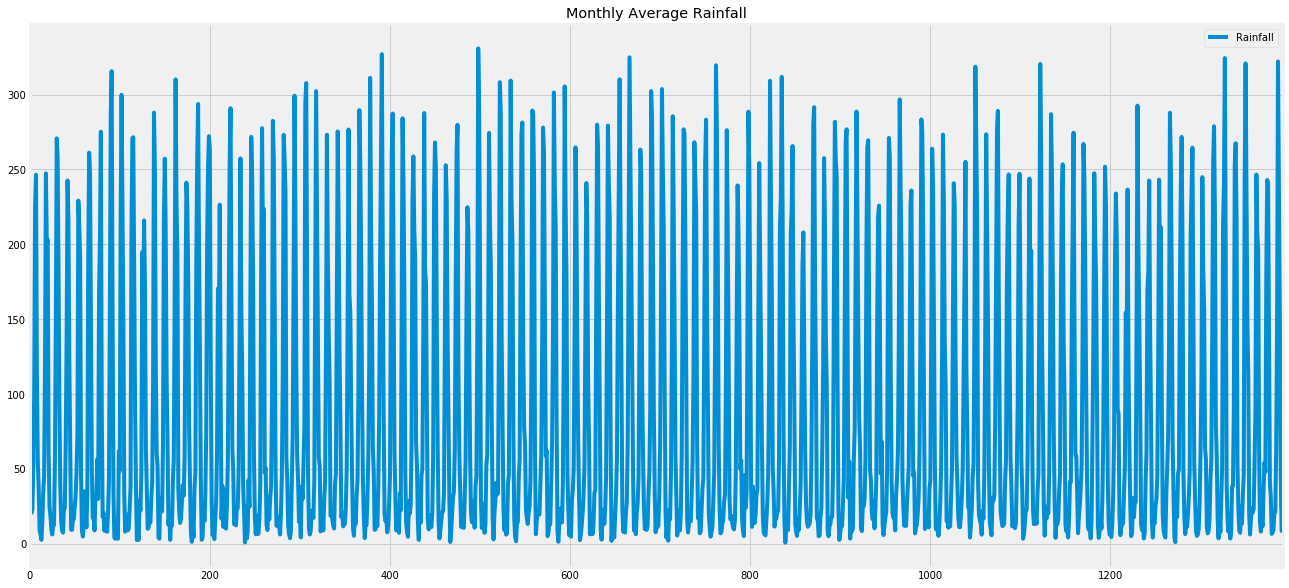

In [2]:
df = pd.read_csv('pr_1901_2016_IND.csv')

df.plot(figsize=(20,10))
plt.title('Monthly Average Rainfall')
plt.show()

In [3]:
df.head()

,Year,Rainfall
0,31-01-1901,29.8409
1,28-02-1901,21.2770
2,31-03-1901,20.6549
3,30-04-1901,22.9126
4,31-05-1901,51.8245


In [4]:
df.describe()

,Rainfall
count,1392.000000
mean,88.069133
std,92.259252
min,0.853890
25%,16.038150
50%,42.209000
75%,153.396000
max,330.852000


## Data Inspection

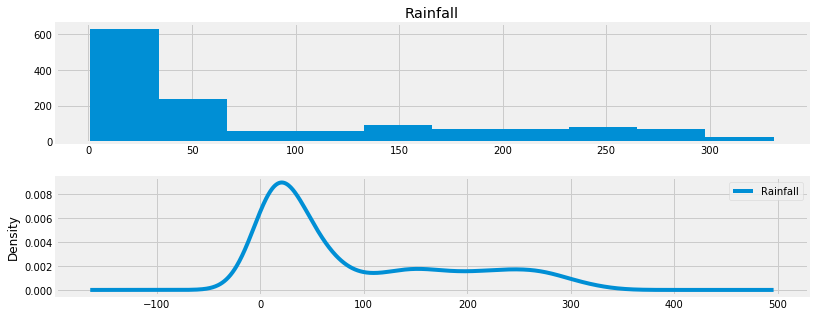

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
df.hist(ax=ax1)
df.plot(kind='kde', ax=ax2)
plt.show();

## Model Identification and Model Selection

### 1. Time Series Decomposition

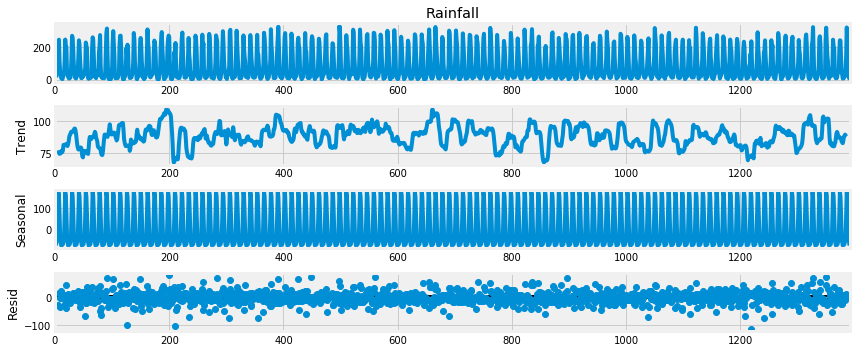

In [6]:
decomposition = seasonal_decompose(df['Rainfall'], freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 5
decomposition.plot()
plt.show();

In [7]:
df.drop('Year', inplace=True, axis=1)

### 2. ACF and PACF Plots

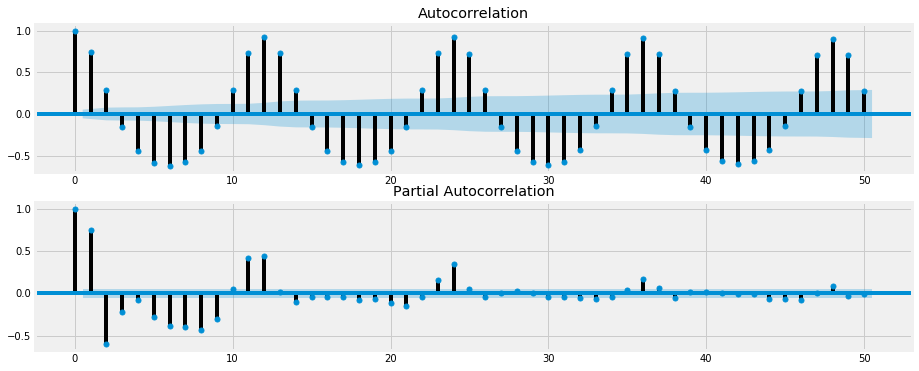

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

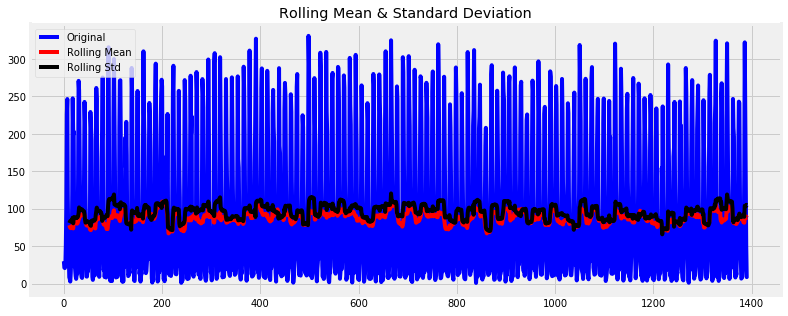

In [9]:
#Determing rolling statistics
rolmean = pd.Series(df['Rainfall']).rolling(window=12).mean()
rolstd = pd.Series(df['Rainfall']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Rainfall'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Statistical Tests

In [10]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Rainfall'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.306982e+00
p-value                        3.305078e-08
#Lags Used                     2.300000e+01
Number of Observations Used    1.368000e+03
Critical Value (1%)           -3.435139e+00
Critical Value (5%)           -2.863655e+00
Critical Value (10%)          -2.567896e+00
dtype: float64


In [11]:
df_diff = df.diff().diff(12)

In [12]:
df_diff.dropna(inplace=True)

In [13]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['Rainfall'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.375582e+01
p-value                        1.030145e-25
#Lags Used                     2.400000e+01
Number of Observations Used    1.354000e+03
Critical Value (1%)           -3.435189e+00
Critical Value (5%)           -2.863677e+00
Critical Value (10%)          -2.567908e+00
dtype: float64


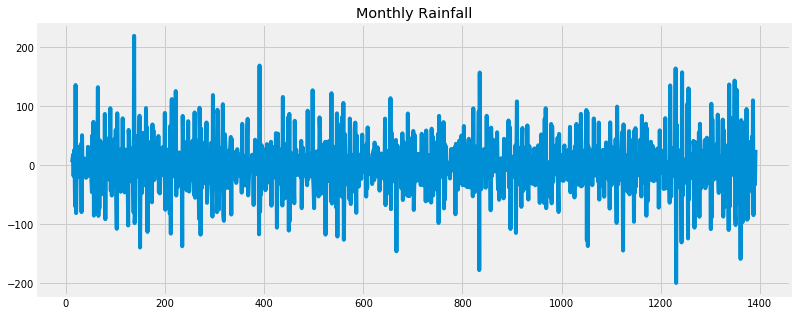

In [14]:
plt.plot(df_diff['Rainfall'])
plt.title('Monthly Rainfall')
plt.savefig('diffplot')
plt.show()

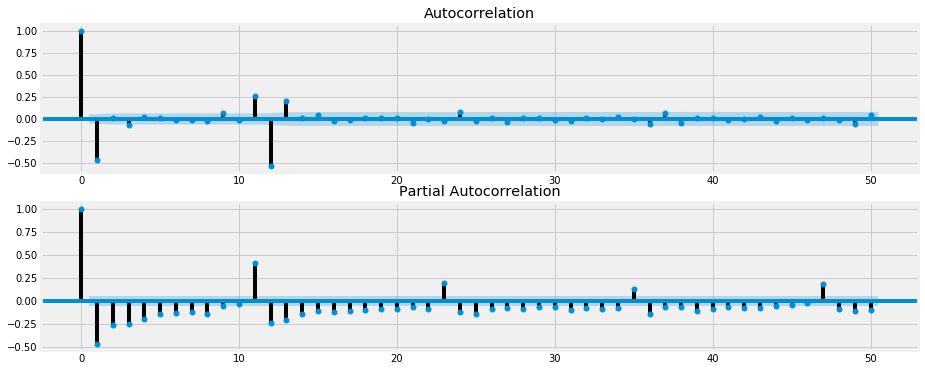

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

## Model Parameter Estimation

In [16]:
import pmdarima as pm
model = pm.auto_arima(df['Rainfall'], d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14253.323, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13445.681, Time=2.97 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13926.395, Time=0.70 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13331.546, Time=9.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13682.383, Time=7.75 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=13231.017, Time=12.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13341.949, Time=4.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=16.32 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=13159.994, Time=15.08 sec
 ARIMA(3,1,0)(1,1,0)[12]             

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1392
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6534.409
Date:                            Thu, 08 Apr 2021   AIC                          13086.818
Time:                                    12:48:32   BIC                          13133.880
Sample:                                         0   HQIC                         13104.424
                                           - 1392                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0086      0.754      0.011      0.991      -1.469       1.486
ar.L1         -0.7325      0.022    -32.930      0.000      -0.776      -0.689
ar.L2         -0.5304      0.028    -19.091      0.000      -0.585      -0.476
ar.L3         -0.4200      0.034    -12.349      0.000      -0.487      -0.353
ar.L4         -0.2878      0.037     -7.797      0.000      -0.360      -0.215
ar.L5         -0.1433      0.037     -3.828      0.000      -0.217      -0.070
ar.S.L12      -0.6995      0.020    -35.417      0.000      -0.738      -0.661
ar.S.L24      -0.2812      0.021    -13.344      0.000      -0.322      -0.240
sigma2       760.5835     21.199     35.878      0.000     719.034     802.133
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               209.02
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.10
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

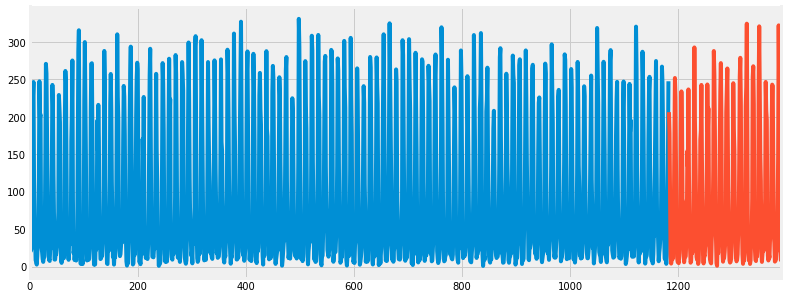

In [18]:
#divide into train and validation set
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

#plotting the data
train['Rainfall'].plot()
test['Rainfall'].plot()

In [19]:
model = SARIMAX(train['Rainfall'],order=(5,1,0),seasonal_order=(2,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Rainfall   No. Observations:                 1183
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -5522.162
Date:                            Thu, 08 Apr 2021   AIC                          11060.323
Time:                                    12:49:48   BIC                          11100.841
Sample:                                         0   HQIC                         11075.605
                                           - 1183                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7187      0.024    -29.935      0.000      -0.766      -0.672
ar.L2         -0.5239      0.031    -16.891      0.000      -0.585      -0.463
ar.L3         -0.4025      0.036    -11.217      0.000      -0.473      -0.332
ar.L4         -0.2833      0.039     -7.260      0.000      -0.360      -0.207
ar.L5         -0.1399      0.040     -3.524      0.000      -0.218      -0.062
ar.S.L12      -0.6812      0.022    -30.970      0.000      -0.724      -0.638
ar.S.L24      -0.2664      0.023    -11.764      0.000      -0.311      -0.222
sigma2       732.2336     21.879     33.468      0.000     689.352     775.115
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               196.54
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Validation

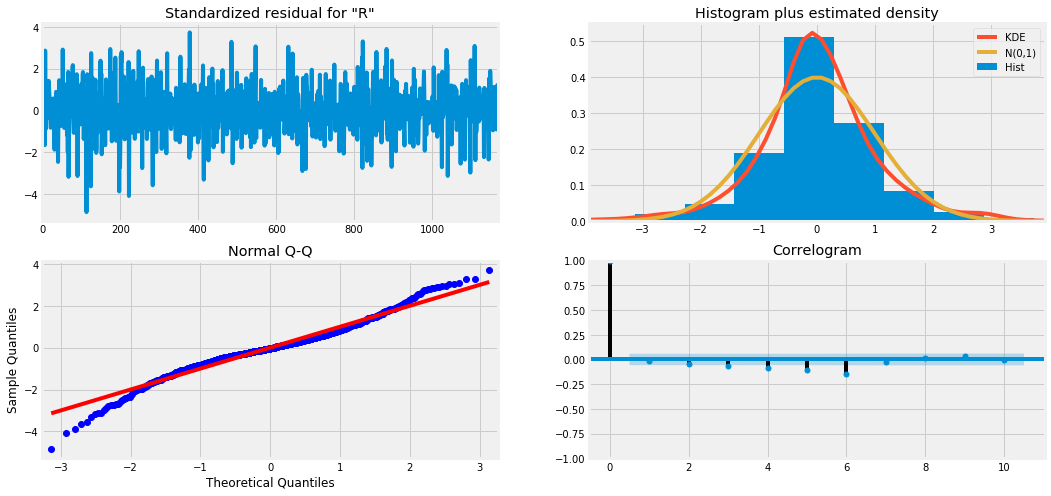

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

## Prediction Analysis using SARIMA

In [21]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

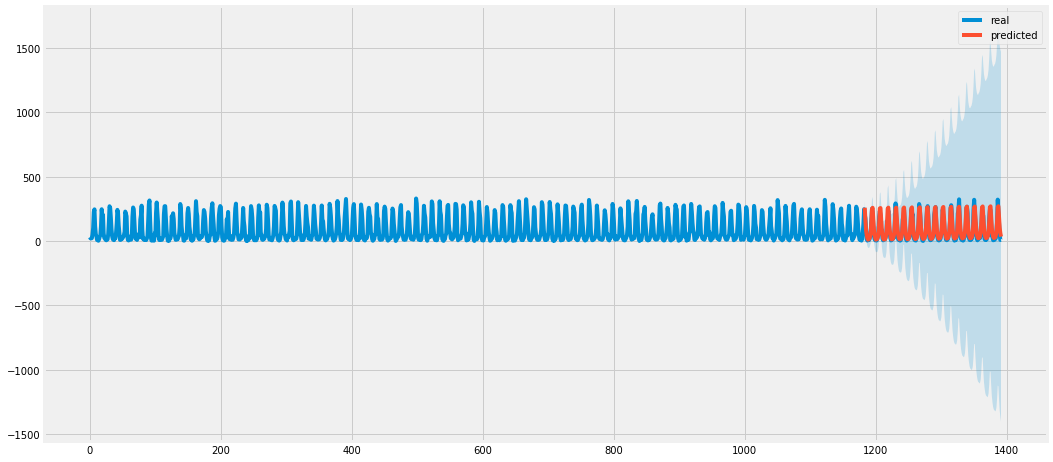

In [22]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(df.index, df, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

In [23]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(5,1,0)(2,1,0,12) Predictions')

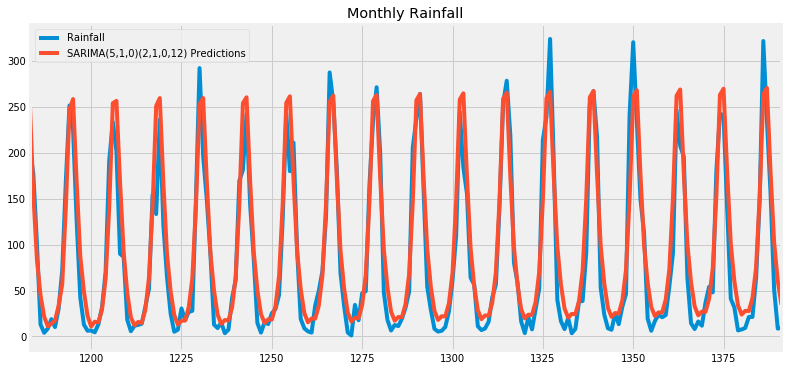

In [24]:
# Plot predictions against known values
title = 'Monthly Rainfall'
ax = test['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [25]:
r2_score(test['Rainfall'], predictions)

0.8924511858254119

## Future Forecasts

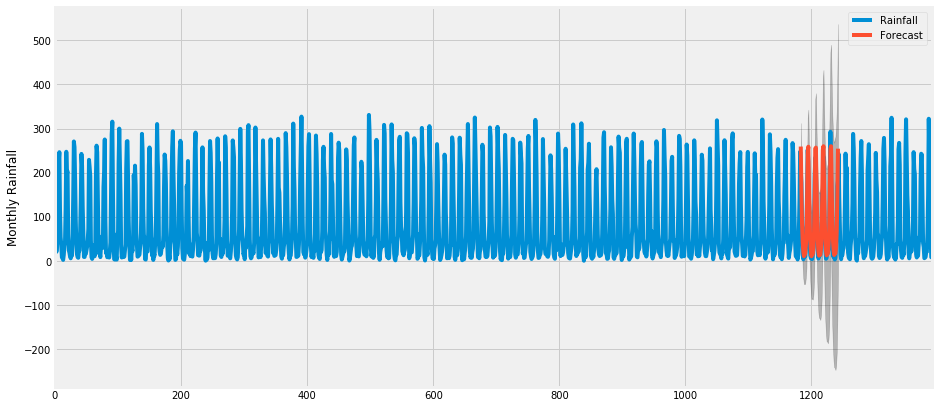

In [30]:
pred_f = results.get_forecast(steps=60)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Production', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel('Monthly Rainfall')
plt.legend()
plt.show()